# Dynamic Economic Emissions Dispatch (i.e. DEED)
This notebook details the basics of DEED via openai gym.

## Cost Function Inputs

$P_i^m\>$power output of ith unit at time m

$P^{min}_i ; P^{max}_i\>$    lower and upper generation limits for $i^{th}$ unit

$P_{Dm}\>$ load demand at time $t$

$P_{Lm}\>$ transmission line losses at time $m$

$a_i,b_i, c_i,d_i, ei\>$ cost coefficients of $i^{th}$ unit

$\alpha_i,\beta_i, \gamma_i,\eta_i,\delta_i\>$ emission coefficients of $i^{th}$ unit

$UR_i,DR_i\>$ ramp-up and ramp-down rate limits of ith unit

$N\>$ number of generating units

$M\>$ number of hours in the time horizon

**Create Environment**

Environments all descend from the Env base class. You can view a list of all environments via:

```
from gym import envs
print(envs.registry.all())
```

Important environment functions/properties:

**step**: Returns info regarding what our actions are doing to the 

* environment at each step. The return values:
* observation (object)
* reward (float)
* done (boolean)
* info (dict)
**reset**: returns an initial observation.
**Space objects**: two objects (below) that describe the valid actions and observations.

* action_space [returns Discrete(2) for cartpole]. Example usage of Discrete: 

```
python from gym import spaces space = spaces.Discrete(8) # Set with 8 elements {0, 1, 2, ..., 7} x = space.sample() assert space.contains(x) assert space.n == 8
```

* observation_space [returns Box(4) for cartpole]


In [0]:
import gym
from gym import spaces
import pandas as pd  # import pandas to use pandas DataFrame
from math import sin
from math import exp
from pandas import Series


class Generators(gym.Env):
    """Class for Generators environment"""
    metadata = {'render.modes': ['human']}

    # Set constants
    N = 10  # N = number of generators
    M = 24  # M = number of hours in day
    E = 10  # Emissions scaling factor

    # DataFrame created whith generator data in the form of list of tuples
    generator_characteristics = pd.DataFrame(
        [(150, 470, 786.7988, 38.5397, 0.1524, 450, 0.041, 103.3908, -2.4444, 0.0312, 0.5035, 0.0207, 80, 80),
         (135, 470, 451.3251, 46.1591, 0.1058, 600, 0.036, 103.3908, -2.4444, 0.0312, 0.5035, 0.0207, 80, 80),
         (73, 340, 1049.9977, 40.3965, 0.0280, 320, 0.028, 300.3910, -4.0695, 0.0509, 0.4968, 0.0202, 80, 80),
         (60, 300, 1243.5311, 38.3055, 0.0354, 260, 0.052, 300.3910, -4.0695, 0.0509, 0.4968, 0.0202, 50, 50),
         (73, 243, 1658.5696, 36.3278, 0.0211, 280, 0.063, 320.0006, -3.8132, 0.0344, 0.4972, 0.0200, 50, 50),
         (57, 160, 1356.6592, 38.2704, 0.0179, 310, 0.048, 320.0006, -3.8132, 0.0344, 0.4972, 0.0200, 50, 50),
         (20, 130, 1450.7045, 36.5104, 0.0121, 300, 0.086, 330.0056, -3.9023, 0.0465, 0.5163, 0.0214, 30, 30),
         (47, 120, 1450.7045, 36.5104, 0.0121, 340, 0.082, 330.0056, -3.9023, 0.0465, 0.5163, 0.0214, 30, 30),
         (20, 80, 1455.6056, 39.5804, 0.1090, 270, 0.098, 350.0056, -3.9524, 0.0465, 0.5475, 0.0234, 30, 30),
         (10, 55, 1469.4026, 40.5407, 0.1295, 380, 0.094, 360.0012, -3.9864, 0.0470, 0.5475, 0.0234, 30, 30)],
        columns=["p_min_i", "p_max_i", "a_i", "b_i", "c_i", "d_i", "e_i", "alpha_i", "beta_i", "gamma_i", "eta_i",
                 "delta_i", "ur_i", "dr_i"],
        index=["unit1", "unit2", "unit3", "unit4", "unit5", "unit6", "unit7", "unit8", "unit9", "unit10"])

    # B is the matrix of transmission line loss coefficients
    # data in the form of list of tuples
    B = pd.DataFrame(
        [(0.000049, 0.000014, 0.000015, 0.000015, 0.000016, 0.000017, 0.000017, 0.000018, 0.000019, 0.000020),
         (0.000014, 0.000045, 0.000016, 0.000016, 0.000017, 0.000015, 0.000015, 0.000016, 0.000018, 0.000018),
         (0.000015, 0.000016, 0.000039, 0.000010, 0.000012, 0.000012, 0.000014, 0.000014, 0.000016, 0.000016),
         (0.000015, 0.000016, 0.000010, 0.000040, 0.000014, 0.000010, 0.000011, 0.000012, 0.000014, 0.000015),
         (0.000016, 0.000017, 0.000012, 0.000014, 0.000035, 0.000011, 0.000013, 0.000013, 0.000015, 0.000016),
         (0.000017, 0.000015, 0.000012, 0.000010, 0.000011, 0.000036, 0.000012, 0.000012, 0.000014, 0.000015),
         (0.000017, 0.000015, 0.000014, 0.000011, 0.000013, 0.000012, 0.000038, 0.000016, 0.000016, 0.000018),
         (0.000018, 0.000016, 0.000014, 0.000012, 0.000013, 0.000012, 0.000016, 0.000040, 0.000015, 0.000016),
         (0.000019, 0.000018, 0.000016, 0.000014, 0.000015, 0.000014, 0.000016, 0.000015, 0.000042, 0.000019),
         (0.000020, 0.000018, 0.000016, 0.000015, 0.000016, 0.000015, 0.000018, 0.000016, 0.000019, 0.000044)])

    # self.state = np.array([0.0,74.0,148.0,148.0,74.0,148.0,74.0,74.0,148.0,98.0,84.0,44.0,-78.0,-148.0,-148.0,-222.0,-74.0,148.0,148.0,196.0,-48.0,-296.0,-296.0,-148.0])
    # data in the form of list of tuples
    hour_power_demand = pd.DataFrame(
        [1036, 1110, 1258, 1406, 1480, 1628, 1702, 1776, 1924, 2022, 2106, 2150, 2072, 1924,
         1776, 1554, 1480, 1628, 1776, 1972, 1924, 1628, 1332, 1184],
        columns=["p_d"],
        index=["hour1", "hour2", "hour3", "hour4", "hour5", "hour6", "hour7", "hour8", "hour9", "hour10", "hour11",
               "hour12", "hour13", "hour14", "hour15", "hour16", "hour17", "hour18", "hour19", "hour20", "hour21",
               "hour22", "hour23", "hour24"])

    def __init__(self):
        print("Generators Environment Initialised")

        df = self.hour_power_demand.diff()
        df2 = pd.DataFrame(
            [0, 1036, 1110, 1258, 1406, 1480, 1628, 1702, 1776, 1924, 2022, 2106, 2150, 2072, 1924,
             1776, 1554, 1480, 1628, 1776, 1972, 1924, 1628, 1332],
            columns=["P_n_(m-1)"],
            index=["hour1", "hour2", "hour3", "hour4", "hour5", "hour6", "hour7", "hour8", "hour9", "hour10", "hour11",
                   "hour12", "hour13", "hour14", "hour15", "hour16", "hour17", "hour18", "hour19", "hour20", "hour21",
                   "hour22", "hour23", "hour24"])

        df["P_n_(m-1)"] = Series(df2.loc[:, "P_n_(m-1)"], index=df.index)
        self.state = df
        print(self.state)
        self.active_unit = "unit1"
        self.counter = 0
        self.done = 0
        self.add = [0, 0]
        self.reward = 0
        self.action_space = spaces.Discrete(101)  # Set with 101 elements {0, 1, 2 ... 100}

    def show_unit_characteristics(self, unit):
        print("Unit Name:", unit)
        print(self.generator_characteristics.loc[unit, :])

    def cost_function_local(self, unit):
        a_n = self.generator_characteristics.loc[unit, "a_i"]
        b_n = self.generator_characteristics.loc[unit, "b_i"]
        c_n = self.generator_characteristics.loc[unit, "c_i"]
        d_n = self.generator_characteristics.loc[unit, "d_i"]
        e_n = self.generator_characteristics.loc[unit, "e_i"]
        P_min_n = self.generator_characteristics.loc[unit, "p_min_i"]
        P_n_m = np.random.uniform(low=self.generator_characteristics.loc[unit, "p_min_i"],
                                  high=self.generator_characteristics.loc[unit, "p_max_i"])
        return round(a_n + (b_n * P_n_m) + c_n * (P_n_m ** 2) + abs(d_n * sin(e_n * (P_min_n - P_n_m))), 2)

    def cost_function_global(self):
        global_cost = 0
        for i, row in self.generator_characteristics.iterrows():
            global_cost += self.cost_function_local(i)
        return round(global_cost, 2)

    def emissions_function_local(self, unit):
        alpha_n = self.generator_characteristics.loc[unit, "alpha_i"]
        beta_n = self.generator_characteristics.loc[unit, "beta_i"]
        gamma_n = self.generator_characteristics.loc[unit, "gamma_i"]
        eta_n = self.generator_characteristics.loc[unit, "eta_i"]
        delta_n = self.generator_characteristics.loc[unit, "delta_i"]
        P_min_n = self.generator_characteristics.loc[unit, "p_min_i"]
        P_n_m = np.random.uniform(low=self.generator_characteristics.loc[unit, "p_min_i"],
                                  high=self.generator_characteristics.loc[unit, "p_max_i"])
        return self.E * (alpha_n + (beta_n * P_n_m) + gamma_n * (P_n_m ** 2) + eta_n * exp(delta_n * P_n_m))

    def emissions_function_global(self):
        global_emissions = 0
        for i, row in self.generator_characteristics.iterrows():
            global_emissions += self.emissions_function_local(i)
        return global_emissions

        # Show full dataFrame
        # print(generator_characteristics)

        # select a column by name (i.e. label)
        # print(generator_characteristics.loc[:, "b_i"])

        # Get numpy array instead of pandas series
        # print(generator_characteristics.loc[:, "b_i"]).values

        # Select a unit by label
        # print(generator_characteristics.loc["unit3", :])

        # Select rows based on cloumn value
        # print(generator_characteristics.loc[generator_characteristics.loc[:, "dr_i"] <= 50, :])

        # Select a specific unit value by label
        # print(generator_characteristics.loc["unit3", "d_i"])
        # Show full dataFrame

        # --------------------------------------------------------------------------------

        # Select a specific unit value by its index
        # print(B.iloc[0,0])

        # Show full dataFrame
        # print(hour_power_demand)

        # ax = hour_power_demand.plot(title="HOURLY POWER DEMAND", kind="bar", color='red')

        # ax.set_xlabel("Hour")
        # ax.set_ylabel("MW")

    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        P_n = self.generator_characteristics.loc[self.active_unit, "p_min_i"] + action * ((
                                                                                                      self.generator_characteristics.loc[
                                                                                                          self.active_unit, "p_max_i"] -
                                                                                                      self.generator_characteristics.loc[
                                                                                                          self.active_unit, "p_min_i"]) / 100)
        print(P_n)
        state = self.state
        if self.done == 1:
            print("Game Over")
            return [self.state, self.reward, self.done, self.add]
        else:
            print("Game in progress")
            return [self.state, self.reward, self.done, self.add]

    def render(self):
        print("This is a render of the Generators Environment")

    def reset(self):
        print("Generators Environment Reset")
        # self.state = hour_power_demand.diff()
        self.state = []
        self.counter = 0
        self.done = 0
        self.add = [0, 0]
        self.reward = 0
        # space = spaces.Discrete(24) # Set with 8 elements {0, 1, 2, ..., 23}
        # self.action_space = spaces.Tuple((spaces.Discrete(101)))


# delete if it's registered
env_name = 'Generators-v0'
if env_name in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs[env_name]

# register the environment so we can play with it
gym.register(
    id=env_name,
    entry_point=Generators
)

In [0]:
#os.chdir('/content')
#!rm -rf gym-foo
#!pip install cookiecutter
#!cookiecutter https://github.com/nbren12/gym_environment_cookie
#!pip install -e git+https://github.com/danielcregg/gym-generators#egg=gym-generators
#!pip install -e git+https://github.com/apoddar573/Tic-Tac-Toe-Gym_Environment#egg=Tic-Tac-Toe-Gym_Environment
#!pip install -e git+https://github.com/apoddar573/Tic-Tac-Toe-Gym_Environment/tree/master/gym-tictac4#egg=gym-tictac4
 #!pip install -e /content/src/tic-tac-toe-gym-environment/gym-tictac4
#!pip install -e /content/gym-generators
#import os
#os.chdir('/content/gym-foo')
#!pip install -e .
#import gym_foo
#gym_foo

#import importlib.util
#spec = importlib.util.spec_from_file_location("gym_foo", "/content/gym-foo")
#bar = importlib.util.module_from_spec(spec)
#spec.loader.exec_module(bar)

In [1]:
%%writefile qlearning.py
from collections import defaultdict
import random, math
import numpy as np

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on http://inst.eecs.berkeley.edu/~cs188/sp09/pacman.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #<YOUR CODE HERE>
        q_value = []
        for action in possible_actions:
            q_value.append(self.get_qvalue(state,action))
        value = max(q_value)
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #<YOUR CODE HERE>
        new_qvalue = (1-learning_rate) * self.get_qvalue(state,action) + learning_rate * (reward+gamma*self.get_value(next_state))
        self.set_qvalue(state, action, new_qvalue)

    
    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #<YOUR CODE HERE>
        q_value = []
        for action in possible_actions:
            q_value.append(self.get_qvalue(state,action))
        q_value = np.array(q_value)
        best_action = possible_actions[np.argmax(q_value)]
        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).
        
        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = self.get_best_action(state)#None

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon

        #<YOUR CODE HERE>
        if np.random.rand() < epsilon:
            chosen_action = np.random.choice(possible_actions)
        else:
            chosen_action = action
        return chosen_action

Writing qlearning.py


In [2]:
import os
import gym

# Install custom gym environment
!pip install -e git+https://github.com/danielcregg/gym-generators#egg=gym-generators > /dev/null

os.chdir('/content/src/gym-generators')
import gym_generators
os.chdir('/content')

# Delete environment registration if it's registered
env_name = 'Generators-v0'
if env_name in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs[env_name]

# register the environment so we can use it with gym
gym.register(
    id='Generators-v0',
    entry_point='gym_generators.envs:GeneratorsEnv'
)

env = gym.make("Generators-v0")

#env = gym.make("Taxi-v2")


n_actions = env.action_space.n
#print(env.action_space)
#print(env.action_space.n)
#print(env.action_space.sample())




#env.reset()


#env.show_unit_characteristics("unit5")

#print(env.cost_function_local("unit5"))
#print(env.cost_function_global())
#print(env.emissions_function_local("unit1"))
#print(env.emissions_function_global())

  Running command git clone -q https://github.com/danielcregg/gym-generators /content/src/gym-generators
Generators Environment Initialising...
Generators Environment Initialised...


**CREATE AGENTS SECTION**

In [3]:
from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))

print(env.reset())
print(agent.get_legal_actions(20))

Generators Environment Reset
[  0.  428.4]
range(0, 101)


In [0]:
from qlearning import QLearningAgent

agent_u2 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))
agent_u3 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))
agent_u4 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))
agent_u5 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))
agent_u6 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))
agent_u7 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))
agent_u8 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))
agent_u9 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))
agent_u10 = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.75,
                       get_legal_actions = lambda s: range(n_actions))

**TRAINING DAY**

In [0]:
def play_and_train(env,agent,t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)#<YOUR CODE>
        
        #print(env.step(a))
        next_s, r, done, _ = env.step(a)
       
        # train (update) agent for state s
        agent.update(s,a,r,next_s)
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward

In [0]:
def play_and_train_all_agents(env,agent_u2,agent_u3,agent_u4,agent_u5,agent_u6,agent_u7,agent_u8,agent_u9,agent_u10,t_max=24):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s then feed forward new state.
        action_u2 = agent_u2.get_action(s)
        next_s_u2, r_u2, done_u2, _ = env.step(action_u2)
        
        
      
        
        action_u3 = agent_u3.get_action(next_s_u2)
        next_s_u3, r_u3, done_u3, _ = env.step(action_u3)
        action_u4 = agent_u4.get_action(next_s_u3)
        next_s_u4, r_u4, done_u4, _ = env.step(action_u4)
        action_u5 = agent_u5.get_action(next_s_u4)
        next_s_u5, r_u5, done_u5, _ = env.step(action_u5)
        action_u6 = agent_u6.get_action(next_s_u5)
        next_s_u6, r_u6, done_u6, _ = env.step(action_u6)
        action_u7 = agent_u7.get_action(next_s_u6)
        next_s_u7, r_u7, done_u7, _ = env.step(action_u7)
        action_u8 = agent_u8.get_action(next_s_u7)
        next_s_u8, r_u8, done_u8, _ = env.step(action_u8)
        action_u9 = agent_u9.get_action(next_s_u8)
        next_s_u9, r_u9, done_u9, _ = env.step(action_u9)
        action_u10 = agent_u10.get_action(next_s_u9)
        next_s_u10, r_u10, done_u10, _ = env.step(action_u10)
        
        #print(env.step(a))
        
        
 
        # train (update) agent for state s
        agent_u2.update(s,action_u2,r_u2,next_s_u2)
        agent_u3.update(next_s_u2,action_u3,r_u3,next_s_u3)
        
        agent_u4.update(next_s_u3,action_u4,r_u4,next_s_u4)
        
        agent_u5.update(next_s_u4,action_u5,r_u5,next_s_u5)
        
        agent_u6.update(next_s_u5,action_u6,r_u6,next_s_u6)
        
        agent_u7.update(next_s_u6,action_u7,r_u7,next_s_u7)
        
        agent_u8.update(next_s_u7,action_u8,r_u8,next_s_u8)
        
        agent_u9.update(next_s_u8,action_u9,r_u9,next_s_u9)
        
        agent_u10.update(next_s_u9,action_u10,r_u10,next_s_u10)
        
        s = next_s_u10

        total_reward += (r_u2 + r_u3 + r_u4 + r_u5 + r_u6 + r_u7 + r_u8 + r_u9 + r_u10)
        #if done: break
        
    return total_reward

In [0]:
#print(play_and_train(env, agent, 30))
print(play_and_train_all_agents(env,agent_u2,agent_u3,agent_u4,agent_u5,agent_u6,agent_u7,agent_u8,agent_u9,agent_u10))

In [0]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

mean reward = -314015274297.5475


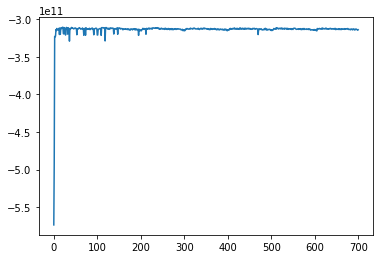

Generators Environment Reset
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Generators Environment Reset
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episode Complete.
Episod

In [0]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train_all_agents(env,agent_u2,agent_u3,agent_u4,agent_u5,agent_u6,agent_u7,agent_u8,agent_u9,agent_u10))
    agent_u2.epsilon *= 0.99
    agent_u3.epsilon *= 0.99
    agent_u4.epsilon *= 0.99
    agent_u5.epsilon *= 0.99
    agent_u6.epsilon *= 0.99
    agent_u7.epsilon *= 0.99
    agent_u8.epsilon *= 0.99
    agent_u9.epsilon *= 0.99
    agent_u10.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        #print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        print('mean reward =', np.mean(rewards[-10:]))     
        plt.plot(rewards)
        plt.show()

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

initialise q table

In [0]:
import numpy as np
#q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table = np.zeros([9, 9])

Agent code below:





In [0]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.75
epsilon = 0.05

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 20001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Display single episode

In [0]:
"""Dispaly agent's performance after Q-learning"""
from IPython.display import clear_output
from time import sleep

state = env.reset()
epochs, penalties, reward = 0, 0, 0
frames = [] # for animation


def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.5)
    clear_output(wait=True)
    print(frame['frame'].getvalue())
    print(f"Total Timesteps: {i}")
    print("Total Penalties: {}".format(penalties)) 



done = False
while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1

    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    
    epochs += 1
    
print_frames(frames)

**Evaluating the agent**

---

Q(state,action)←(1−α)Q(state,action)+α(reward+γmaxaQ(next state,all actions))


In [0]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Creating Generator Environment

In [0]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

import pandas as pd

from scipy.optimize import curve_fit as cf

In [0]:
#@title Cost Function Inputs
#@markdown Input Fileds

Pm = 102  #@param {type: "number"}




no_type_checking = "Test"  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 100  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "tuesday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


In [0]:
w = Pm + slider_value
display(w)

##Cost Equation

\begin{equation*}
\left( \sum_{k=1}^n a_k b_k \right)^2 \leq \left( \sum_{k=1}^n a_k^2 \right) \left( \sum_{k=1}^n b_k^2 \right)
\end{equation*}


**Resources**

[Reinforcement Q-Learning from Scratch in Python with OpenAI Gym](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)

In [0]:
#@title Cost Function
#@markdown Input Fileds



Pim power output of ith unit at time m
P min
i ; P max
i lower and upper generation limits for ith unit
PDm load demand at time t
PLm transmission line losses at time m
ai,bi, ci,di, ei cost coefficients of ith unit
ai,bi, ci,gi,di emission coefficients of ith unit
URi,DRi ramp-up and ramp-down rate limits of ith unit
N number of generating units
M number of hours in the time horizon


no_type_checking = "Test"  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 159  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "tuesday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


In [0]:
print("hello")

In [0]:
#@title Example form fields
#@markdown Forms support many types of fields.

no_type_checking = "Test"  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 159  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "tuesday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Code cells
Below is a **code cell**. Once the toolbar button indicates CONNECTED, click in the cell to select it and execute the contents in the following ways:

* Click the **Play icon** in the left gutter of the cell;
* Type **Cmd/Ctrl+Enter** to run the cell in place;
* Type **Shift+Enter** to run the cell and move focus to the next cell (adding one if none exists); or
* Type **Alt+Enter** to run the cell and insert a new code cell immediately below it.

There are additional options for running some or all cells in the **Runtime** menu.


In [0]:
a = 10
a

## Text cells
This is a **text cell**. You can **double-click** to edit this cell. Text cells
use markdown syntax. To learn more, see our [markdown
guide](/notebooks/markdown_guide.ipynb).

You can also add math to text cells using [LaTeX](http://www.latex-project.org/)
to be rendered by [MathJax](https://www.mathjax.org). Just place the statement
within a pair of **\$** signs. For example `$\sqrt{3x-1}+(1+x)^2$` becomes
$\sqrt{3x-1}+(1+x)^2.$


## Adding and moving cells
You can add new cells by using the **+ CODE** and **+ TEXT** buttons that show when you hover between cells. These buttons are also in the toolbar above the notebook where they can be used to add a cell below the currently selected cell.

You can move a cell by selecting it and clicking **Cell Up** or **Cell Down** in the top toolbar. 

Consecutive cells can be selected by "lasso selection" by dragging from outside one cell and through the group.  Non-adjacent cells can be selected concurrently by clicking one and then holding down Ctrl while clicking another.  Similarly, using Shift instead of Ctrl will select all intermediate cells.

# Working with python
Colaboratory is built on top of [Jupyter Notebook](https://jupyter.org/). Below are some examples of convenience functions provided.

Long running python processes can be interrupted. Run the following cell and select **Runtime -> Interrupt execution** (*hotkey: Cmd/Ctrl-M I*) to stop execution.

In [0]:
import time
print("Sleeping")
time.sleep(30) # sleep for a while; interrupt me!
print("Done Sleeping")

## System aliases

Jupyter includes shortcuts for common operations, such as ls:

In [0]:
!ls /bin

That `!ls` probably generated a large output. You can select the cell and clear the output by either: 

1. Clicking on the clear output button (x) in the toolbar above the cell; or
2. Right clicking the left gutter of the output area and selecting "Clear output" from the context menu.

Execute any other process using `!` with string interpolation from python variables, and note the result can be assigned to a variable:

In [0]:
message = 'Colaboratory is great!'
foo = !echo -e '$message\n$message'
foo

## Magics
Colaboratory shares the notion of magics from Jupyter. There are shorthand annotations that change how a cell's text is executed. To learn more, see [Jupyter's magics page](http://nbviewer.jupyter.org/github/ipython/ipython/blob/1.x/examples/notebooks/Cell%20Magics.ipynb). 


In [0]:
%%html
<marquee style='width: 30%; color: blue;'><b>Whee!</b></marquee>

In [0]:
%%html
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 450 400" width="200" height="200">
  <rect x="80" y="60" width="250" height="250" rx="20" style="fill:red; stroke:black; fill-opacity:0.7" />
  <rect x="180" y="110" width="250" height="250" rx="40" style="fill:blue; stroke:black; fill-opacity:0.5;" />
</svg>

## Tab-completion and exploring code

Colab provides tab completion to explore attributes of Python objects, as well as to quickly view documentation strings. As an example, first run the following cell to import the  [`numpy`](http://www.numpy.org) module.

In [0]:
import numpy as np

If you now insert your cursor after ``np.random.`` and press **Tab**, you will see the list of available completions within the ``np.random`` submodule.

In [0]:
np.random.

If you type an open parenthesis followed by the **Tab** key after any function or class in the module, you will see a pop-up of its documentation string:

In [0]:
np.random.rand(

To open the documentation in a persistent pane at the bottom of your screen, add a **?** after the object or method name and execute the cell using **Shift+Enter**:

In [0]:
np.random?

## Exception Formatting

Exceptions are formatted nicely in Colab outputs:

In [0]:
x = 1
y = 4
z = y/(1-x)

## Rich, interactive outputs
Until now all of the generated outputs have been text, but they can be more interesting, like the chart below. 

In [0]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Fills and Alpha Example")
plt.show()

# Integration with Drive

Colaboratory is integrated with Google Drive. It allows you to share, comment, and collaborate on the same document with multiple people:

* The **SHARE** button (top-right of the toolbar) allows you to share the notebook and control permissions set on it.

* **File->Make a Copy** creates a copy of the notebook in Drive.

* **File->Save** saves the File to Drive. **File->Save and checkpoint** pins the version so it doesn't get deleted from the revision history. 

* **File->Revision history** shows the notebook's revision history. 

* Multiple people can **collaboratively edit** the same notebook at the same time. Like Google Docs, you can see collaborators both within the document (top right, left of the comments button) and within a cell (right of the cell). 

## Commenting on a cell
You can comment on a Colaboratory notebook like you would on a Google Document. Comments are attached to cells, and are displayed next to the cell they refer to. If you have **comment-only** permissions, you will see a comment button on the top right of the cell when you hover over it.

If you have edit or comment permissions you can comment on a cell in one of three ways: 

1. Select a cell and click the comment button in the toolbar above the top-right corner of the cell.
1. Right click a text cell and select **Add a comment** from the context menu.
3. Use the shortcut **Ctrl+Shift+M** to add a comment to the currently selected cell. 

You can resolve and reply to comments, and you can target comments to specific collaborators by typing *+[email address]* (e.g., `+user@domain.com`). Addressed collaborators will be emailed. 

The Comment button in the top-right corner of the page shows all comments attached to the notebook.

## Test Display


In [0]:
import gym

env = gym.make('CartPole-v0')

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env.reset()
#env.render(mode='rgb_array')
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)



In [0]:
#SSHing into Colab notebook
# Generate root password
import random, string
password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))

#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
#Print root password
print("Root password: {}".format(password))
#Get public address
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"